<a href="https://colab.research.google.com/github/MRdvan/Pytorch-Training/blob/master/Pytorch-fundamentals-to-deploy/01_Pytorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow of pytorch
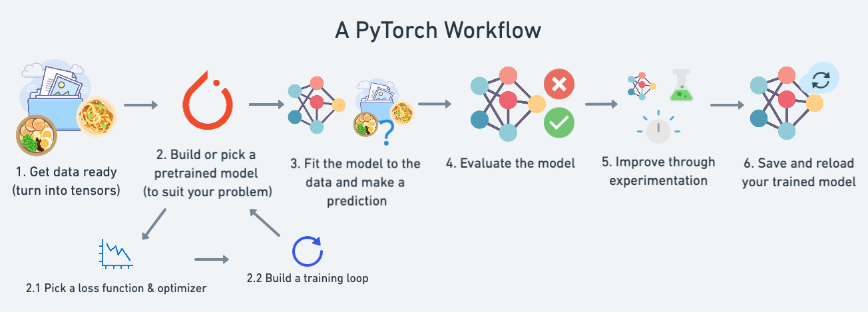


In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.12.1+cu113'

## 1- Data (preparing and loading)

In [ ]:
# we will create data to fit a straight line
weight = 0.7
bias = 0.3

X = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = weight * X + bias #y=x*w.T+b

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  
  plt.figure(figsize = (10,7))
  plt.scatter(train_data,train_labels,c="b",s=4,label= "Training data")
  plt.scatter(test_data,test_labels,c="g",s=4,label= "Testing data")
  if predictions is not None:
    plt.scatter(test_data,predictions,c="r",s=4,label= "Predictions")
  
  plt.legend(prop={"size":14})

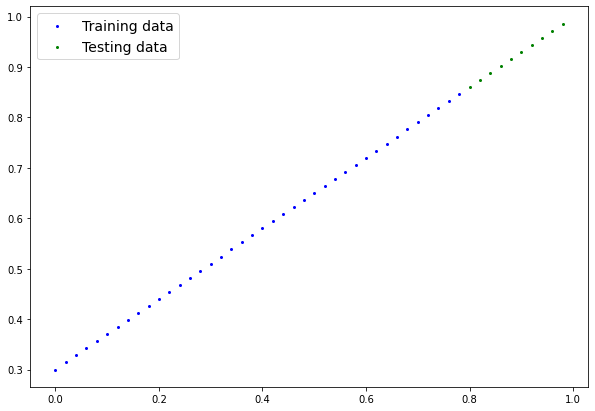

In [ ]:
plot_predictions()

## 2- Build Model

In [ ]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters
    # self.linear_layer = nn.Linear(in_features=1, out_features=1)
    self.weights = nn.Parameter(torch.randn(1,
            requires_grad=True,
            dtype=torch.float 
        ))

    self.bias = nn.Parameter(torch.randn(1,
        requires_grad=True,
        dtype=torch.float
    ))
  def forward(self ,x:torch.Tensor) -> torch.Tensor:
    #return self.linear_layer(x)
    return self.weights*x+self.bias


In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Make predictions with model (turns of gradient tracking)
with torch.inference_mode(): 
    y_preds = model_0(X_test)#this part calls the forward method
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")
print(f"real values:\n{X_test}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])
real values:
tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])


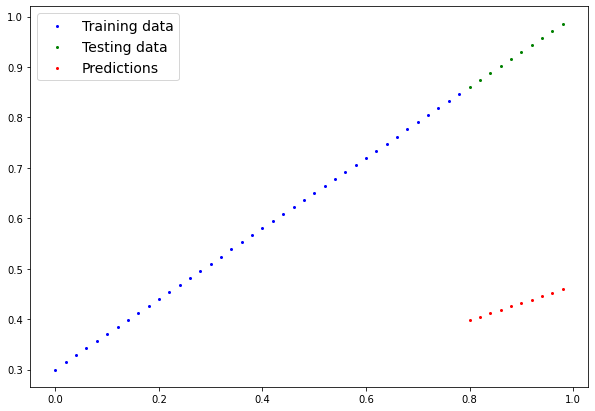

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds
# this it kinda our loss values

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train model

We need loss function and optimizer to train our model

* **loss function :** measures how wrong our models predistions compared to the labels
(torch.nn),
(l1loss,bce)

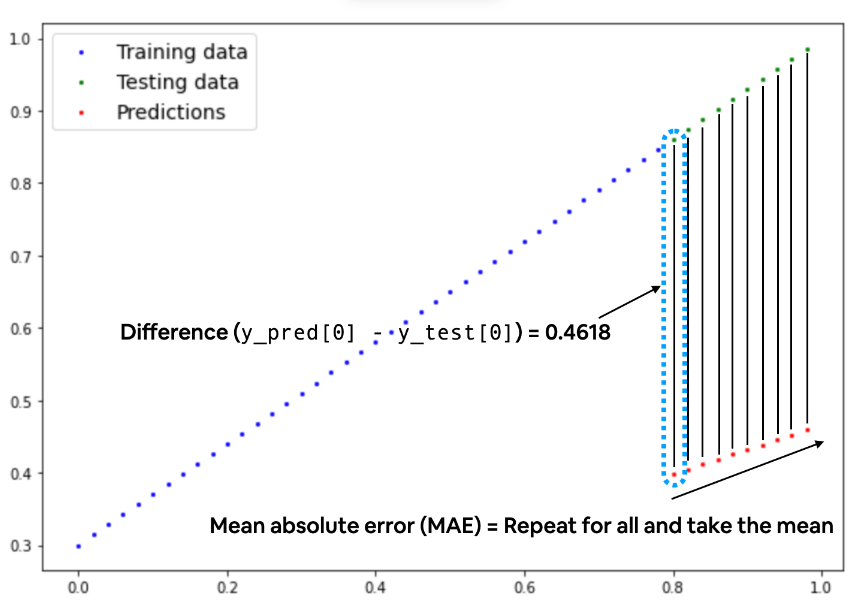

* **optimizer :** how to update models parameters to best that lower the loss
(torch.optim),(sgd,adam)

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() #L1Loss (mean squared error)

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)#paramaters that gonna be optimize and learning_rate to how much scale the update steps

* Calculate the loss (loss = ...) before performing backpropagation on it (loss.backward()).
* Zero gradients (optimizer.zero_grad()) before stepping them (optimizer.step()).
* Step the optimizer (optimizer.step()) after performing backpropagation on the loss (loss.backward()).

In [ ]:
torch.manual_seed(42)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# Put data on the available device if working with GPU
#X_train = X_train.to(device)
#X_test = X_test.to(device)
#y_train = y_train.to(device)
#y_test = y_test.to(device)

### Training
for epoch in range(epochs):

    # Put model in training mode
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing
    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():# no gradient tracking for this statements 
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 10 | MAE Train Loss: 0.021020207554101944 | MAE Test Loss: 0.04819049686193466 
Epoch: 20 | MAE Train Loss: 0.01758546568453312 | MAE Test Loss: 0.04060482233762741 
Epoch: 30 | MAE Train Loss: 0.014155393466353416 | MAE Test Loss: 0.03233227878808975 
Epoch: 40 | MAE Train Loss: 0.010716589167714119 | MAE Test Loss: 0.024059748277068138 
Epoch: 50 | MAE Train Loss: 0.0072835334576666355 | MAE Test Loss: 0.016474086791276932 
Epoch: 60 | MAE Train Loss: 0.0038517764769494534 | MAE Test Loss: 0.008201557211577892 
Epoch: 70 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 80 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 90 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 100 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 110 | MAE Train Loss: 0.0089

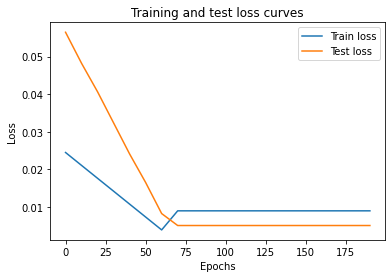

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
print(model_0.state_dict())
print(".............")
print(f"weights: {weight}, bias: {bias}")


OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
.............
weights: 0.7, bias: 0.3


## 4. Making predictions with a trained PyTorch model




1.   Set the model in evaluation mode (model.eval()).
2.   Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3.   All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).




In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. if use gpu add these two statement 
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

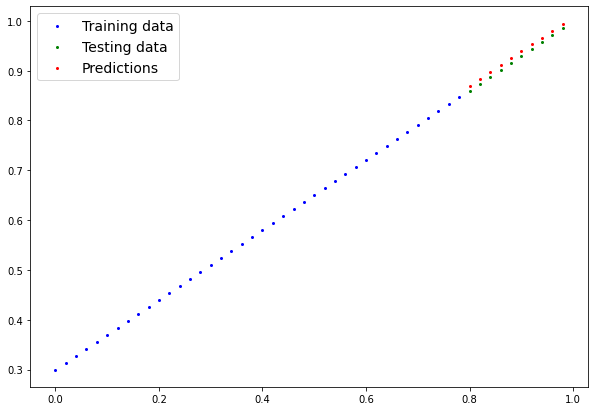

In [ ]:
plot_predictions(predictions=y_preds)
# Put data on the CPU and plot it
#plot_predictions(predictions=y_preds.cpu())

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# New linearregression model to load weights and bias parameters
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH)) #torch.load() -> returns state_dict from model that we only need

<All keys matched successfully>

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model
    
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])